In [1]:
#Import Packages
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import warnings
import nltk
import string
import seaborn as sns
from nltk.stem.porter import * 
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train=pd.read_csv("D:/STATISTIKA/PERSIAPAN MENUJU MAGISTER/digitaltalent/Materi AI DTS 2019/PROJECT 4/EI-reg-En-train/data.csv")

In [3]:
test=pd.read_csv("D:/STATISTIKA/PERSIAPAN MENUJU MAGISTER/digitaltalent/Materi AI DTS 2019/PROJECT 4/2018-EI-reg-En-dev/datadev.csv")

In [4]:
#Comining both Train and Test Data Set before Data Cleaning
# since Label Column is not present in test Dataset, the values are filled with NaN (sudah dijadikan satu antara testing dan training)
combine = train.append(test,ignore_index=True)
print('Shape of new Dataset:',combine.shape)
combine.tail()

Shape of new Dataset: (8566, 5)


,Unnamed: 0,ID,Tweet,Affect Dimension,Intensity Score
8561,1459,2018-En-00994,@JeffBezos @amazon Who can I talk to about bei...,sadness,0.553
8562,1460,2018-En-03770,Brown envelopes can induce panic. #posttruth,sadness,0.522
8563,1461,2018-En-02331,I wont rt things that might offend your faves ...,sadness,0.400
8564,1462,2018-En-04002,and after i got home in such a horrible mood m...,sadness,0.727
8565,1463,2018-En-02112,hit by a sudden wave of sadness,sadness,0.800


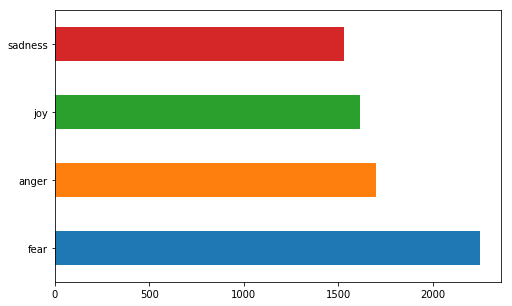

In [122]:
#jumlah data train
train['Affect Dimension'].value_counts().plot('barh',figsize=(8,5))

In [123]:
train['Affect Dimension'].value_counts()

fear       2252
anger      1701
joy        1616
sadness    1533
Name: Affect Dimension, dtype: int64

In [125]:
test.shape

(1464, 5)

In [124]:
test['Affect Dimension'].value_counts()

sadness    397
fear       389
anger      388
joy        290
Name: Affect Dimension, dtype: int64

In [5]:
#User Defined Function to clean unwanted text patterns from all tweets
# input - text to clean,pattern to replace
def cleantext(inputword,pattern):
    r = re.findall(pattern=pattern,string=inputword)
    for i in r:
        inputword = re.sub(pattern=i,repl='',string=inputword)
    return inputword

In [8]:
#Removing all twitter handles because they are already masked as @user due to privacy concerns.
#These twitter handles hardly give any information about the nature of the tweet.
combine['cleanedText'] = np.vectorize(cleantext)(combine['Tweet'],'@[\w]*')
combine.head()

,Unnamed: 0,ID,Tweet,Affect Dimension,Intensity Score,cleanedText
0,0,2017-En-10264,@xandraaa5 @amayaallyn6 shut up hashtags are c...,anger,0.562,shut up hashtags are cool #offended
1,1,2017-En-10072,it makes me so fucking irate jesus. nobody is ...,anger,0.750,it makes me so fucking irate jesus. nobody is ...
2,2,2017-En-11383,Lol Adam the Bull with his fake outrage...,anger,0.417,Lol Adam the Bull with his fake outrage...
3,3,2017-En-11102,@THATSSHAWTYLO passed away early this morning ...,anger,0.354,passed away early this morning in a fast and ...
4,4,2017-En-11506,@Kristiann1125 lol wow i was gonna say really?...,anger,0.438,lol wow i was gonna say really?! haha have yo...


In [9]:
combine['cleanedText'] = combine['cleanedText'].str.replace("[^a-zA-Z#]"," ")
combine.head()

,Unnamed: 0,ID,Tweet,Affect Dimension,Intensity Score,cleanedText
0,0,2017-En-10264,@xandraaa5 @amayaallyn6 shut up hashtags are c...,anger,0.562,shut up hashtags are cool #offended
1,1,2017-En-10072,it makes me so fucking irate jesus. nobody is ...,anger,0.750,it makes me so fucking irate jesus nobody is ...
2,2,2017-En-11383,Lol Adam the Bull with his fake outrage...,anger,0.417,Lol Adam the Bull with his fake outrage
3,3,2017-En-11102,@THATSSHAWTYLO passed away early this morning ...,anger,0.354,passed away early this morning in a fast and ...
4,4,2017-En-11506,@Kristiann1125 lol wow i was gonna say really?...,anger,0.438,lol wow i was gonna say really haha have yo...


In [10]:
combine['cleanedText'] = combine['cleanedText'].str.replace(r'\b(\w{1,2})\b', '')
combine.head()

,Unnamed: 0,ID,Tweet,Affect Dimension,Intensity Score,cleanedText
0,0,2017-En-10264,@xandraaa5 @amayaallyn6 shut up hashtags are c...,anger,0.562,shut hashtags are cool #offended
1,1,2017-En-10072,it makes me so fucking irate jesus. nobody is ...,anger,0.750,makes fucking irate jesus nobody calling ...
2,2,2017-En-11383,Lol Adam the Bull with his fake outrage...,anger,0.417,Lol Adam the Bull with his fake outrage
3,3,2017-En-11102,@THATSSHAWTYLO passed away early this morning ...,anger,0.354,passed away early this morning fast and fur...
4,4,2017-En-11506,@Kristiann1125 lol wow i was gonna say really?...,anger,0.438,lol wow was gonna say really haha have you...


In [11]:
#Tokenize the tweets
tokenized_tweets = combine['cleanedText'].apply(lambda x:x.split())
tokenized_tweets.head()

0               [shut, hashtags, are, cool, #offended]
1    [makes, fucking, irate, jesus, nobody, calling...
2     [Lol, Adam, the, Bull, with, his, fake, outrage]
3    [passed, away, early, this, morning, fast, and...
4    [lol, wow, was, gonna, say, really, haha, have...
Name: cleanedText, dtype: object

In [12]:
#Stemming the words to remove words with similar meaning
stemmer = PorterStemmer()
tokenized_tweets = tokenized_tweets.apply(lambda x : [stemmer.stem(i) for i in x]  )

In [13]:
tokenized_tweets.head()

0                  [shut, hashtag, are, cool, #offend]
1    [make, fuck, irat, jesu, nobodi, call, ppl, wh...
2       [lol, adam, the, bull, with, hi, fake, outrag]
3    [pass, away, earli, thi, morn, fast, and, furi...
4    [lol, wow, wa, gonna, say, realli, haha, have,...
Name: cleanedText, dtype: object

In [14]:
#Joining the tokenized tweets

for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])    
combine['cleanedText'] = tokenized_tweets
combine.head()

,Unnamed: 0,ID,Tweet,Affect Dimension,Intensity Score,cleanedText
0,0,2017-En-10264,@xandraaa5 @amayaallyn6 shut up hashtags are c...,anger,0.562,shut hashtag are cool #offend
1,1,2017-En-10072,it makes me so fucking irate jesus. nobody is ...,anger,0.750,make fuck irat jesu nobodi call ppl who like h...
2,2,2017-En-11383,Lol Adam the Bull with his fake outrage...,anger,0.417,lol adam the bull with hi fake outrag
3,3,2017-En-11102,@THATSSHAWTYLO passed away early this morning ...,anger,0.354,pass away earli thi morn fast and furiou style...
4,4,2017-En-11506,@Kristiann1125 lol wow i was gonna say really?...,anger,0.438,lol wow wa gonna say realli haha have you seen...


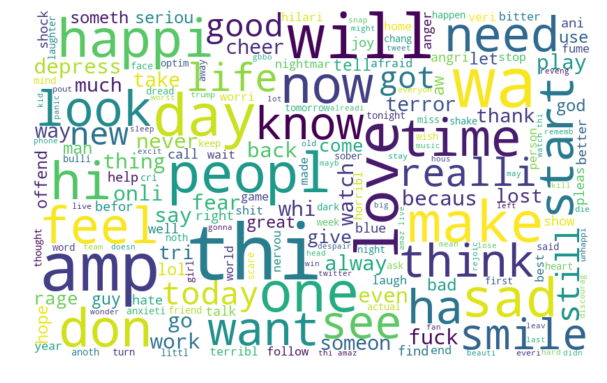

In [22]:
# Creating word Cloud for all Words in all tweets
allWords = ' '.join([text for text in combine['cleanedText']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color="white").generate(allWords)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

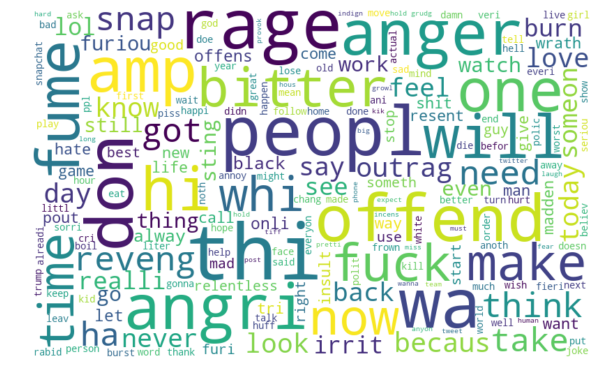

In [17]:
# Creating word Cloud for all Words in all anger tweets
positiveWords = ' '.join([text for text in combine['cleanedText'][combine['Affect Dimension'] == 'anger']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color="white").generate(positiveWords)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

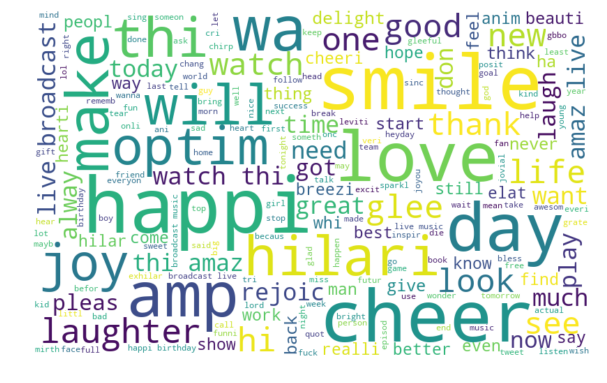

In [18]:
# Creating word Cloud for all Words in all joy tweets
positiveWords = ' '.join([text for text in combine['cleanedText'][combine['Affect Dimension'] == 'joy']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color="white").generate(positiveWords)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

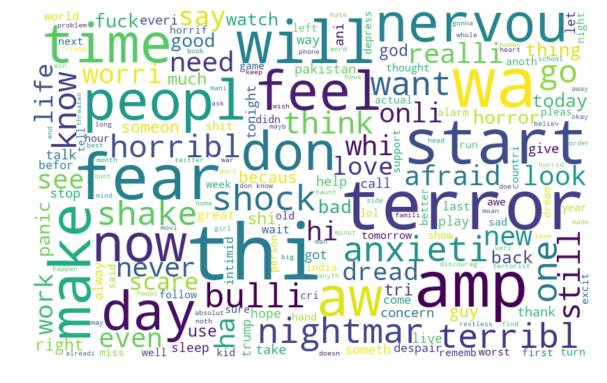

In [19]:
# Creating word Cloud for all Words in all fear tweets
positiveWords = ' '.join([text for text in combine['cleanedText'][combine['Affect Dimension'] == 'fear']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color="white").generate(positiveWords)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

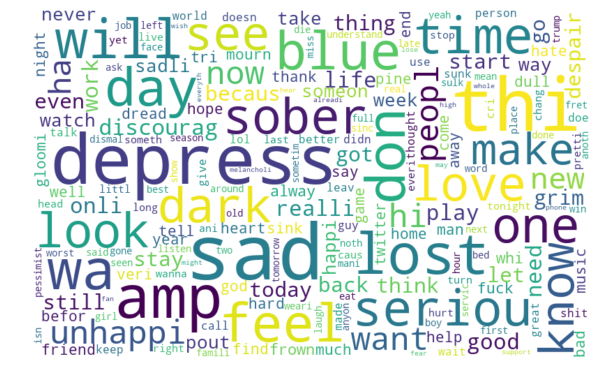

In [21]:
# Creating word Cloud for all Words in all sadness tweets
positiveWords = ' '.join([text for text in combine['cleanedText'][combine['Affect Dimension'] == 'sadness']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color="white").generate(positiveWords)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [23]:
#Function Collecting HashTag
def collectHashtag(x):
    hashtags = []    
    for i in x:        
        ht = re.findall(r"#(\w+)", i)        
        hashtags.append(ht)     
    return hashtags

In [24]:
#Collect all the hashtags in emotion tweets
HT_anger = collectHashtag(combine['cleanedText'][combine['Affect Dimension'] == "anger"])
#Nested List to Un-nested List
HT_anger = sum(HT_anger,[])

HT_joy = collectHashtag(combine['cleanedText'][combine['Affect Dimension'] == "joy"])
#Nested List to Un-nested List
HT_joy = sum(HT_joy,[])

HT_fear = collectHashtag(combine['cleanedText'][combine['Affect Dimension'] == "fear"])
HT_fear = sum(HT_fear,[])

HT_sadness = collectHashtag(combine['cleanedText'][combine['Affect Dimension'] == "sadness"])
HT_sadness = sum(HT_sadness,[])

In [25]:
corpus_anger = nltk.FreqDist(HT_anger)
corpus_fear = nltk.FreqDist(HT_fear)
corpus_joy = nltk.FreqDist(HT_joy)
corpus_sadness = nltk.FreqDist(HT_sadness)

In [38]:
d = pd.DataFrame({'Hashtag':list(corpus_anger.keys()),'Count':list(corpus_anger.values())})
d = d.nlargest(columns='Count',n=20)
d

,Hashtag,Count
15,angri,53
4,bitter,48
8,rage,48
7,fume,47
19,anger,44
31,reveng,38
0,offend,31
58,snap,24
22,outrag,22
2,relentless,15


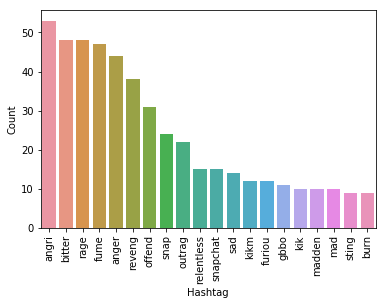

<Figure size 1152x360 with 0 Axes>

In [32]:
ax = sns.barplot(data = d,x = 'Hashtag',y = 'Count')
plt.figure(figsize=(16,5))
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

      Hashtag  Count
21     terror     97
45       fear     64
25         aw     61
7      nervou     53
34   nightmar     51
108   terribl     50
5     anxieti     49
76      shock     49
9      horror     42
8       bulli     38
20      panic     36
26    horribl     36
2      afraid     30
13      start     27
125  pakistan     26
527   depress     24
4       worri     22
79   restless     18
154     trump     18
50       gbbo     17


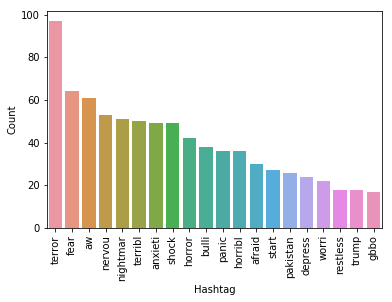

<Figure size 1152x360 with 0 Axes>

In [39]:
d1 = pd.DataFrame({'Hashtag':list(corpus_fear.keys()),'Count':list(corpus_fear.values())})
d1 = d1.nlargest(columns='Count',n=20)
print(d1)
ax = sns.barplot(data = d1,x = 'Hashtag',y = 'Count')
plt.figure(figsize=(16,5))
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

      Hashtag  Count
45      smile     83
17      happi     77
21      music     54
29     hilari     52
3       optim     47
104      live     42
19   laughter     27
66       glee     24
93      cheer     24
33       love     23
99        joy     23
184      quot     21
171     funni     15
5        gbbo     14
76        lol     14
39     rejoic     11
117    inspir     11
222    beauti     10
512     laugh     10
36    success      9


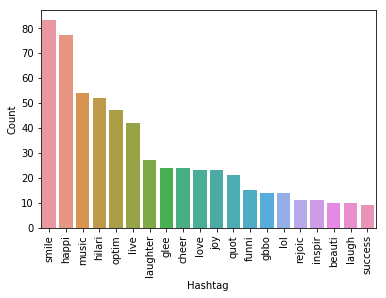

<Figure size 1152x360 with 0 Axes>

In [40]:
d2 = pd.DataFrame({'Hashtag':list(corpus_joy.keys()),'Count':list(corpus_joy.values())})
d2 = d2.nlargest(columns='Count',n=20)
print(d2)
ax = sns.barplot(data = d2,x = 'Hashtag',y = 'Count')
plt.figure(figsize=(16,5))
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

          Hashtag  Count
39            sad    109
15        depress     85
4            blue     53
9            lost     50
17          sober     36
23         seriou     34
47        unhappi     30
31           dark     27
27        anxieti     19
19          music     16
99           gbbo     13
105          grim     12
486           cri     11
34         mhchat     10
219       despair     10
356          quot     10
48   mentalhealth      8
128      recoveri      8
29           rock      7
250          hurt      7


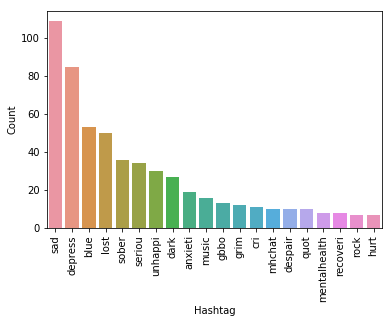

<Figure size 1152x360 with 0 Axes>

In [41]:
d3 = pd.DataFrame({'Hashtag':list(corpus_sadness.keys()),'Count':list(corpus_sadness.values())})
d3 = d3.nlargest(columns='Count',n=20)
print(d3)
ax = sns.barplot(data = d3,x = 'Hashtag',y = 'Count')
plt.figure(figsize=(16,5))
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

## extraction feature

In [42]:
#Vectorization
#Importing Required Packages

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import gensim

In [43]:
#Applying Bag of Words Vectorization to the Tweets
extraction feature menggunakan Bag of word
bow_vectorizer = CountVectorizer(stop_words= 'english')
bow = bow_vectorizer.fit_transform(combine['cleanedText'])

In [53]:
#Applying TF-IDF Vectorization to the Tweets
tfidf_vectorizer = TfidfVectorizer(stop_words= 'english')
tfidf = tfidf_vectorizer.fit_transform(combine['cleanedText'])
tfidf


<8566x10133 sparse matrix of type '<class 'numpy.float64'>'
	with 67102 stored elements in Compressed Sparse Row format>

In [54]:
X=tfidf
y=combine["Affect Dimension"]

In [55]:
#split dataset training and testing
Xtrain=X[:7058]
ytrain=y[:7058]
Xtest=X[7058:8522]
ytest=y[7058:8522]

In [56]:
Xtrain

<7058x10133 sparse matrix of type '<class 'numpy.float64'>'
	with 55227 stored elements in Compressed Sparse Row format>

In [57]:
#RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(Xtrain, ytrain) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [58]:
y_pred = classifier.predict(Xtest)
print(y_pred)

['sadness' 'sadness' 'sadness' ... 'sadness' 'fear' 'fear']


In [59]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(ytest,y_pred))
print(classification_report(ytest,y_pred))
print(accuracy_score(ytest, y_pred))

[[144 166  15  63]
 [ 64 251  14  60]
 [ 11 125 134  20]
 [ 57 170  20 150]]
              precision    recall  f1-score   support

       anger       0.52      0.37      0.43       388
        fear       0.35      0.65      0.46       389
         joy       0.73      0.46      0.57       290
     sadness       0.51      0.38      0.43       397

    accuracy                           0.46      1464
   macro avg       0.53      0.46      0.47      1464
weighted avg       0.52      0.46      0.47      1464

0.46379781420765026


In [61]:
#pakai svm linier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(Xtrain, ytrain)

In [62]:
y_pred2 = clf.predict(Xtest)
print(y_pred2)

['sadness' 'sadness' 'sadness' ... 'sadness' 'sadness' 'fear']


In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(ytest,y_pred2))
print(classification_report(ytest,y_pred2))
print(accuracy_score(ytest, y_pred2))

[[156 133  24  75]
 [ 77 214  27  71]
 [ 25  89 149  27]
 [ 78 144  20 155]]
              precision    recall  f1-score   support

       anger       0.46      0.40      0.43       388
        fear       0.37      0.55      0.44       389
         joy       0.68      0.51      0.58       290
     sadness       0.47      0.39      0.43       397

    accuracy                           0.46      1464
   macro avg       0.50      0.46      0.47      1464
weighted avg       0.48      0.46      0.46      1464

0.4603825136612022


In [64]:
#pakai svm
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='rbf'))
clf_output = clf.fit(Xtrain, ytrain)
clf_output

OneVsRestClassifier(estimator=SVC(C=100.0, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=0.01, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [65]:
y_pred2 = clf.predict(Xtest)
print(y_pred2)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(ytest,y_pred2))
print(classification_report(ytest,y_pred2))
print(accuracy_score(ytest, y_pred2))

['sadness' 'sadness' 'sadness' ... 'sadness' 'fear' 'fear']
[[161 134  22  71]
 [ 79 214  27  69]
 [ 30  87 141  32]
 [ 74 138  22 163]]
              precision    recall  f1-score   support

       anger       0.47      0.41      0.44       388
        fear       0.37      0.55      0.44       389
         joy       0.67      0.49      0.56       290
     sadness       0.49      0.41      0.45       397

    accuracy                           0.46      1464
   macro avg       0.50      0.47      0.47      1464
weighted avg       0.49      0.46      0.47      1464

0.46379781420765026


## mencoba extrasi feature menggunakan hstack dan ngram dalam bentuk matriks

In [66]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))
vectorized_data = count_vectorizer.fit_transform(combine["cleanedText"])
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))
indexed_data

<8566x65813 sparse matrix of type '<class 'numpy.int64'>'
	with 196563 stored elements in COOrdinate format>

In [72]:
targets=combine["Affect Dimension"]

In [110]:
#from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=1464, random_state=None)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

TypeError: 'coo_matrix' object is not subscriptable

In [100]:
#pakai svm kernel RBF
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='rbf'))
clf_output = clf.fit(data_train, targets_train)

In [101]:
pred22=clf.predict(data_test)

In [102]:
clf.score(data_test, targets_test)

0.7663934426229508

In [106]:
data_test

<1464x65812 sparse matrix of type '<class 'numpy.int64'>'
	with 31433 stored elements in Compressed Sparse Row format>

In [108]:
data_train.shape

(7102, 65812)

In [116]:
np.array(targets_test)

array(['sadness', 'anger', 'fear', ..., 'anger', 'sadness', 'anger'],
      dtype=object)

In [105]:
data_train_index

<7102x1 sparse matrix of type '<class 'numpy.int64'>'
	with 7101 stored elements in Compressed Sparse Row format>

In [113]:
y_pred22 = clf.predict(data_test)

In [114]:
print(y_pred22)

['sadness' 'anger' 'fear' ... 'anger' 'sadness' 'sadness']


In [118]:

print(confusion_matrix(np.array(targets_test),y_pred22))
print(classification_report(np.array(targets_test),y_pred22))
print(accuracy_score(np.array(targets_test),y_pred22))

[[260  31   7  51]
 [ 35 373  11  50]
 [  9  22 276   8]
 [ 47  64   7 213]]
              precision    recall  f1-score   support

       anger       0.74      0.74      0.74       349
        fear       0.76      0.80      0.78       469
         joy       0.92      0.88      0.90       315
     sadness       0.66      0.64      0.65       331

    accuracy                           0.77      1464
   macro avg       0.77      0.76      0.77      1464
weighted avg       0.77      0.77      0.77      1464

0.7663934426229508


In [121]:
#RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(data_train, targets_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [126]:
y_pred23=clf.predict(data_test)
y_pred23

array(['sadness', 'anger', 'fear', ..., 'anger', 'sadness', 'sadness'],
      dtype='<U7')

In [127]:
print(confusion_matrix(np.array(targets_test),y_pred23))
print(classification_report(np.array(targets_test),y_pred23))
print(accuracy_score(np.array(targets_test),y_pred23))

[[260  31   7  51]
 [ 35 373  11  50]
 [  9  22 276   8]
 [ 47  64   7 213]]
              precision    recall  f1-score   support

       anger       0.74      0.74      0.74       349
        fear       0.76      0.80      0.78       469
         joy       0.92      0.88      0.90       315
     sadness       0.66      0.64      0.65       331

    accuracy                           0.77      1464
   macro avg       0.77      0.76      0.77      1464
weighted avg       0.77      0.77      0.77      1464

0.7663934426229508


In [128]:
## SVM linear
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf2 = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf2.fit(data_train, targets_train)

In [129]:
y_predd=clf2.predict(data_test)
y_predd

array(['sadness', 'anger', 'fear', ..., 'anger', 'sadness', 'sadness'],
      dtype='<U7')

In [130]:
print(confusion_matrix(np.array(targets_test),y_predd))
print(classification_report(np.array(targets_test),y_predd))
print(accuracy_score(np.array(targets_test),y_predd))

[[246  47  10  46]
 [ 38 364  14  53]
 [  8  34 264   9]
 [ 41  69  15 206]]
              precision    recall  f1-score   support

       anger       0.74      0.70      0.72       349
        fear       0.71      0.78      0.74       469
         joy       0.87      0.84      0.85       315
     sadness       0.66      0.62      0.64       331

    accuracy                           0.74      1464
   macro avg       0.74      0.74      0.74      1464
weighted avg       0.74      0.74      0.74      1464

0.7377049180327869


Kesimpulannya SVM menggunakan kernel linier dan RBF. menunjukkan lebih bagus menggunakan RBF. Pada praktiknya, feature space dapat memiliki dimensi yang tinggi dari vektor
input space. (Gunn, 1998) Kernel RBF direkomendasikan untuk diuji pertama kali
karena fungsi kernel RBF memiliki performansi yang sama dengan kernel linier pada
parameter tertentu seperti parameter C. C adalah parameter yang menentukan besar
penalti akibat kesalahan dalam klasifikasi data dan nilainya ditentukan oleh pengguna.
Sehingga peran dari C adalah meminimalkan kesalahan pelatihan dan mengurangi
kompleksitas model.